<a href="https://colab.research.google.com/github/xslittlemaggie/Machine-Learning-Projects/blob/master/User_purchase_prediction_LR_RF_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> LendingClub Loan Data Analysis & Model Building Report </center></h1>

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 24px">
    <ol>
        <li><a href="#purpose of the study">Project Understanding</a></li>
        <li><a href="#loading_data">Data Loading</a></li>
        <li><a href="#features exploratory">Data Exploratory</a></li>
        <li><a href="#data preprocessing">Data Preprocessing & Feature Engineering</a></li>
        <li><a href="#model building">Model Buildings</a></li>
        <li><a href="#conclusion">Conclusion</a></li>
    </ol>
</div>
<br>
<hr>

# 0: Import libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode


# 1. Project Understanding

**1. The Purpose：**

The purpose of this project is to analyze the features related to the loan risks and create classification models to detect the fraud in loan. 

**2. The Data:**

The LendingClub dataset loaded from Kaggle competition will be used for this project. 

The raw dataset includes 42538 samples and 145 features, which is large enough for data analysis. 

**3. The models:**

(1). Logistic Regression: Easy understanding

(2). Decision Tree: Easy understanding and comprehensible

(3). Random Forest: Complex, could be more accurate, but less comprehensible

(4). xgboosting: One of the boosting ensembling method

# 2. Load Local dataset cleaned with SQL

Each of the training and testing datasets include 3 files: e.g. 
- The train_df_info : the general features extracted from SLQ
- The train_first_touch_info: the features about the first touch, activity type
- The train_last_touch_info: the features about the last touch, activity type

In [0]:
train = pd.read_csv("/content/train_data.csv")
test = pd.read_csv("/content/test_data.csv")

In [98]:
train.head()

,user_id,total_search_times,unique_days,EmailOpen_times,WebVisit_times,PageView_times,EmailClick_times,FormSubmit_times,first_activity_date,First_EmailOpen,First_ForSubmit,First_EmailClickhrough,First_PageView,First_WebVisit,last_activity_date,Last_EmailOpen,Last_ForSubmit,Last_EmailClickhrough,Last_PageView,Last_WebVisit,purchase_times,is_purchase
0,00002acbe042d69,10,9,9,0,0,0,1,2013-07-11,1,0,0,0,0,2013-08-12,1,0,0,0,0,0,0
1,0000a3a34bd07e6,20,20,20,0,0,0,0,2013-07-04,1,0,0,0,0,2015-02-07,1,0,0,0,0,0,0
2,0000ecf58c94668,20,19,11,0,0,1,1,2013-10-30,0,0,0,0,0,2015-03-19,1,0,0,0,0,6,1
3,00012205dd4613b,2,2,2,0,0,0,0,2013-10-02,1,0,0,0,0,2013-10-30,1,0,0,0,0,0,0
4,000198d39a568cf,2,2,0,0,0,0,0,2014-01-09,0,0,0,0,0,2014-01-10,0,0,0,0,0,1,1


# 2. Get familar with the data & easy data cleaning


Get familiar with the data before data preprocessing, feature engineering, and model building. 
Drop the features which are obviously unrelated to the target, features with all missing values, or featrues with the same values (small variance).

In [99]:
train.shape

(34850, 22)

At the first glance of the data, there are a lot of features with all missing values. 

It it obvious that these features will be removed from the dataset. 

# 3. Preprocessing & Exploratory Analysis

*   Drop the features with more than 99% of same values, cluster the features into several clases
*   View summary statistics and visualize the data, plotting against each of the feature with the responsive feature, **loan_status**
*   Drop the feature if it is not useful for predicting the responsive feature 
*   Missing values replacement



## 3.1 Go through each of the 57 features, cluster them into different class, numerical, categorical, text, etc.

In [100]:
print("Number of features: {}, sample size: {}".format(train.shape[1], train.shape[0]))

Number of features: 22, sample size: 34850


## 3.2 Visualization of the features

### Function for plotting a variable and comparing with loan status:

reference: https://www.kaggle.com/pileatedperch/predicting-charge-off-from-initial-listing-data

In [0]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(loans[col_name], order=sorted(loans[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)
  # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=loans, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)

    plt.tight_layout()

### 3.2.1 Visualization of responsive feature: **is_purchase**

In [102]:
train.is_purchase.value_counts()

0    24254
1    10596
Name: is_purchase, dtype: int64

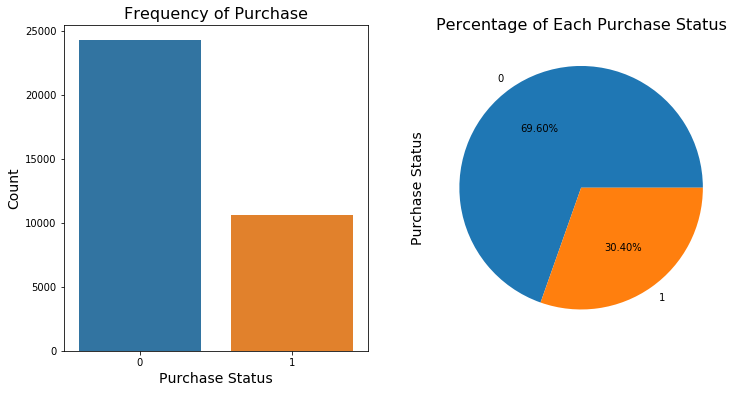

In [103]:
fig, axs = plt.subplots(1, 2, figsize = (12, 6))
sns.countplot(x = "is_purchase", data = train, ax = axs[0])
axs[0].set_title("Frequency of Purchase", size = 16)
axs[0].set_xlabel("Purchase Status", size = 14)
axs[0].set_ylabel("Count", size = 14)

train["is_purchase"].value_counts().plot(x = None, y = None, kind = "pie", ax = axs[1], autopct = "%1.2f%%") # "bar"
axs[1].set_title("Percentage of Each Purchase Status", size = 16)
#axs[1].set_xlabel("Loan", color = "white")
axs[1].set_ylabel("Purchase Status", size = 14)
plt.show()

The responsive feature **is_purchase** is composed of two classes: No (0), & Yes (1). 

**Suggestion:**
The dataset is imbalanced, and need further consideration later.

### 3.3.3 Visualization of the numerical features (连续值特征分布)

### 1. loan_amnt: 
Data Dictionary: "The listed amount of the loan applied for by the borrower."

If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

In [104]:
train.groupby('is_purchase')['total_search_times'].describe()

,count,mean,std,min,25%,50%,75%,max
is_purchase,,,,,,,,
0,24254.0,10.804280,24.278222,1.0,2.0,4.0,11.0,804.0
1,10596.0,28.212722,81.905864,2.0,2.0,4.0,19.0,1968.0


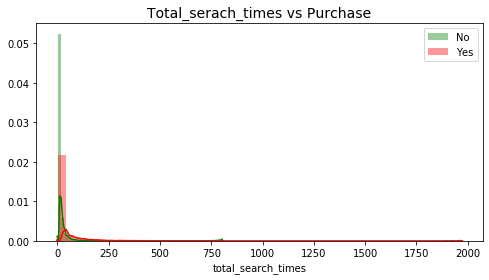

In [105]:
plt.figure(figsize = (8, 4))
df_temp_0 = train["total_search_times"][train.is_purchase == 0]
df_temp_1 = train["total_search_times"][train.is_purchase == 1]
sns.distplot(df_temp_0.dropna(), color = 'g')
sns.distplot(df_temp_1.dropna(), color = 'r')
plt.title("Total_serach_times vs Purchase", size = 14)
plt.legend(['No', 'Yes'])
plt.show()

The purchase  = 1 (Yes) tend to have higher  total_search_times.

# 4. More data preprocessing and feature engineering (数据预处理 & 特征工程)

After the first and second round of data cleaning. The dataset becomes more understandable and managable.

In [106]:
train.shape

(34850, 22)

The dataset looks ok. No missing values.

## 4.1. training, validation, testing datasets split

### 1. About data leakage (警惕数据泄露)

Two things about data leakage

1. The inappropriate features after the determination of the **responsive feature** would lead to data leakage.

2. The inappropriate split of training, validation, testing datasets would also need to data leakage, e.g., fill the missing values with mean, the calculation of the features based on the whole dataset before the data split. 

I have been very careful about these aspects. During the previous steps, when I was filling the missing values or derivative features, I just fill in with constants, or I know even after the separatation of the datasets, the filled values would be the same. 


To avoid data leakage, it's better to split the datasets before data preprocessing. 

In [107]:
from sklearn.model_selection import train_test_split

# split the data
x_col_train = train.columns.tolist()

# remove target variables and other variables from x
features_to_remove = ['user_id', 'is_purchase', 'purchase_times', 'first_activity_date', 'last_activity_date']
for feature in features_to_remove:
  x_col_train.remove(feature)
X = train[x_col_train]
y = train['is_purchase']

# 90% training data, 20% validation data
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

df_train = pd.concat([x_train, y_train], axis = 1)
df_val = pd.concat([x_val, y_val], axis = 1)

# remove variables from test dataset, to make the test dataset consistent with the training dataset
x_col_test = test.columns.tolist()
features_to_remove = ['user_id', 'first_activity_date', 'last_activity_date']
for feature in features_to_remove:
  x_col_test.remove(feature)
df_test = test[x_col_test]
print("The shape of training dataset: {}".format(df_train.shape))
print("The shape of validation dataset: {}".format(df_val.shape))
print("The shape of test dataset: {}".format(df_test.shape))


The shape of training dataset: (27880, 18)
The shape of validation dataset: (6970, 18)
The shape of test dataset: (13643, 17)


## 4.3 Data normalization

逻辑回归模型基于线性回归，求参需要用到梯度下降法，为了加快迭代速度，不同特征的变化范围规模相差不宜过大，如果用数值直接带入逻辑回归模型，必须进行变量缩放。但是本文是用随机森林， 所以这一步可以省略。

Since the normalization will not impact the one-hot-encoding features, and the features with 2 groups. 

I will use normalization

Actually, at the previous data preprocessing, I have transformed the very skewed features. 

In [108]:
df_train.head()

,total_search_times,unique_days,EmailOpen_times,WebVisit_times,PageView_times,EmailClick_times,FormSubmit_times,First_EmailOpen,First_ForSubmit,First_EmailClickhrough,First_PageView,First_WebVisit,Last_EmailOpen,Last_ForSubmit,Last_EmailClickhrough,Last_PageView,Last_WebVisit,is_purchase
10054,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
8487,97,86,74,6,6,3,0,1,0,0,0,0,0,0,0,1,1,1
9552,14,14,14,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
20261,4,2,2,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0
15953,44,44,39,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [109]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
#df_list = []
col = df_train.columns[1:-1]
scaler = StandardScaler()
df_train[col] = scaler.fit_transform(df_train[col])
df_val[col] = scaler.fit_transform(df_val[col])
df_test[col] = scaler.fit_transform(df_test[col])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# 6. Model  building

1) Logistic Regression


2) Random Forest

3) xgboosting

### 6.1 Logistic Regression

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
lr = LogisticRegression()
lr.fit(df_train.drop("is_purchase", axis = 1), df_train["is_purchase"])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Evaluation of the Logistic Regression with confusion_matrix

In [111]:
score = lr.score(df_val.drop("is_purchase", axis = 1), df_val["is_purchase"])
print("The accuracy: {:.5}".format(score))

The accuracy: 0.96169


In [112]:
df_train["is_purchase"].value_counts()/len(df_train)

0    0.694871
1    0.305129
Name: is_purchase, dtype: float64

Since the data is very imbalanced, 85% and 14%, the accuracy is not a good model indicator. Next, I will consider the confusion matrix, and the roc to evaluate the model performance.

In [113]:
y_pred = lr.predict(df_val.drop("is_purchase", axis = 1))
confusion_matrix(df_val["is_purchase"], y_pred)

array([[4881,    0],
       [ 267, 1822]])

In [114]:
from sklearn.metrics import roc_auc_score, roc_curve
auc = roc_auc_score(lr.predict(df_val.drop("is_purchase", axis = 1)), df_val["is_purchase"])
auc

0.974067599067599

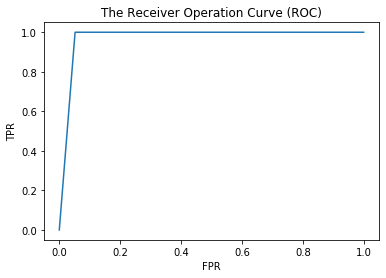

In [115]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.title("The Receiver Operation Curve (ROC)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

### 6.2 Random Forest

The Random Forest is a bagging method based on decisin tree.

随机森林的是以决策树为弱学习模型通过bagging方法构造出的强学习模型，它能容纳更多的信息，同时通过多模型投票，又能很好的避免过拟合的影响，它正好弥补了这一缺陷。这一模型可以作为评分卡的参考。

In [116]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 50)
rfc.fit(df_train.drop("is_purchase", axis = 1), df_train["is_purchase"])
score = rfc.score(df_val.drop("is_purchase", axis = 1), df_val["is_purchase"])
score

0.96987087517934

用网格搜索的方式优化逻辑回归森林模型：

回归森林模型中，n_estimators表示底层决策树个数，一般来说，树的个数越多，模型的稳定性越强，但是它的增大要受限于计算性能

In [0]:
# 网格搜索模型， 对随机森林中的DT个数经行遍历

from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()
parameters = {"n_estimators": [5, 10, 20, 35, 50, 100]}

gs = GridSearchCV(estimator = rf, param_grid = parameters, scoring = "roc_auc", cv = 5, n_jobs = -1)

grid_result = gs.fit(df_train.drop("is_purchase", axis = 1).values, df_train.is_purchase.values)

In [118]:
grid_result.best_score_

0.9962384131513361

In [119]:
grid_result.best_params_

{'n_estimators': 100}

From the result above, the accurayc is 85.6%, and the best roc_auc is 66.39% when n_estimators = 100.

### 6.3 xgboost

The xgboost is a boosting method based on decisin tree.

In [120]:
from xgboost import XGBClassifier
xgc = XGBClassifier()
xgc.fit(df_train.drop("is_purchase", axis = 1), df_train["is_purchase"])
score = xgc.score(df_val.drop("is_purchase", axis = 1), df_val["is_purchase"])
score

0.9423242467718795

In [121]:
auc_xgc = roc_auc_score(xgc.predict(df_val.drop("is_purchase", axis = 1)), df_val["is_purchase"])
auc_xgc

0.9381002418104494

# 7. Comparisons of the three models: Logistic Regression, Random Forest, xgboost

In [122]:
import pandas as pd
models = ["Logistic Regression", "Random Forest", "XGBoost"]
acc = [0.96169, 0.97058, 0.94232]
auc = [0.97406, 0.99615, 0.93810]

res = pd.DataFrame({"Models": models, "Accuracy": acc, "AUC": auc})
res

,Models,Accuracy,AUC
0,Logistic Regression,0.96169,0.97406
1,Random Forest,0.97058,0.99615
2,XGBoost,0.94232,0.93810


From the results above, the accuracy for the 3 models are very similar. Since the data is very imbalanced, the accuracy is not a indicator. 

The Aear Under Curve (ROC) is a good indicator of the model. Based on the AUC, the XGBoost performances best. 

# 7. Conclusion
From the discussion above, after a through data preprocessing and data engineering, 3 models, logistic regression, random forest, xgboost are created and evaluated. Based on the the AUC indicater, the XGBoost performances best. 

## useful reference:
URL_1 = 'https://blog.csdn.net/zs15321583801/article/details/89485951' **(example)**

URL_2 = "https://www.jianshu.com/p/a8037a38e219"

URL_3 = "https://zhuanlan.zhihu.com/p/21550547"

DataCamp = "https://www.datacamp.com/community/tutorials/machine-learning-python"